In [1]:
############ IMPORT LIBRARIES ############
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

In [3]:
%matplotlib inline

# Use a white background for matplotlib figures
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [4]:
############ LOAD DATA ############
# download data (pictures of numbers)
dataset = MNIST(root='data/', download=False, transform=ToTensor())


############ SPLIT DATA ############
val_size = 10000
train_size = len(dataset) - val_size

# training and validation datasets
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

batch_size=128

# training and validations dataloaders
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)


In [5]:
############ NEURAL NETWORK ############
class MnistModel(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        # hidden layer
        self.linear1 = nn.Linear(in_size, hidden_size)
        # output layer
        self.linear2 = nn.Linear(hidden_size, out_size)
        
    def forward(self, xb):
        # Flatten the image tensors
        xb = xb.view(xb.size(0), -1)
        # Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        # Apply activation function
        out = F.relu(out)
        # Get predictions using output layer
        out = self.linear2(out)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))


In [6]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [7]:
############ OUTPUT ############
def evaluate(model, val_loader):
    """Evaluate the model's performance on the validation set"""
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    """Train the model using gradient descent"""
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch) #generate preds + calc loss
            loss.backward()
            optimizer.step() #gradient descent
            optimizer.zero_grad() #reset gradients
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [28]:
input_size = 784
hidden_size = 16 # you can change this
num_classes = 10

model = MnistModel(input_size, hidden_size=hidden_size, out_size=num_classes)

history = [evaluate(model, val_loader)]
history += fit(8, 0.3, model, train_loader, val_loader)
print(history)

Epoch [0], val_loss: 0.3665, val_acc: 0.8854
Epoch [1], val_loss: 0.3033, val_acc: 0.9079
Epoch [2], val_loss: 0.2397, val_acc: 0.9277
Epoch [3], val_loss: 0.2519, val_acc: 0.9254
Epoch [4], val_loss: 0.2090, val_acc: 0.9360
Epoch [5], val_loss: 0.2235, val_acc: 0.9332
Epoch [6], val_loss: 0.2171, val_acc: 0.9363
Epoch [7], val_loss: 0.2077, val_acc: 0.9379
[{'val_loss': 2.3342299461364746, 'val_acc': 0.07158203423023224}, {'val_loss': 0.3664906620979309, 'val_acc': 0.8853515386581421}, {'val_loss': 0.3033047318458557, 'val_acc': 0.907910168170929}, {'val_loss': 0.2397247850894928, 'val_acc': 0.927734375}, {'val_loss': 0.251875638961792, 'val_acc': 0.9253906011581421}, {'val_loss': 0.20901572704315186, 'val_acc': 0.93603515625}, {'val_loss': 0.2235497534275055, 'val_acc': 0.9332031011581421}, {'val_loss': 0.217085599899292, 'val_acc': 0.936328113079071}, {'val_loss': 0.20770418643951416, 'val_acc': 0.9378906488418579}]


<Figure size 864x864 with 0 Axes>

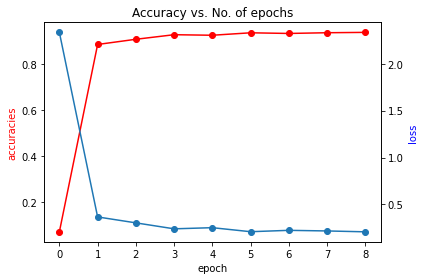

In [33]:
losses = [x['val_loss'] for x in history]
accuracies = [x['val_acc'] for x in history]

plt.figure(figsize=(12,12))

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

locs, labels = plt.xticks()
plt.xticks(np.arange(0,len(losses),step=1))

ax1.plot(accuracies, '-ro')
ax2.plot(losses, '-o')

ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracies', color='red')
ax2.set_ylabel('loss', color='blue')
plt.title('Accuracy vs. No. of epochs')

fig.tight_layout()
plt.show()